# SVM Classifier

In [1]:
from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2grey
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dill
import random
import os
import re
import cv2


* ### Data

In [2]:
# create df of name and label, and shuffle it
img_path = os.path.join(os.getcwd(), "data/raw_data/img_nparrays")
names = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]
labels = [re.sub(r'\d+', '', name) for name in names]
paths = [os.path.join(img_path, f) for f in names]
dict_df = pd.DataFrame(zip(names,paths, labels), columns=['name','path', 'label'], dtype=str)
shuf_df = dict_df.sample(frac=1).reset_index(drop=True)
shuf_df.head()

,name,path,label
0,plastic391,/Users/loaner/Documents/github/trash-classifie...,plastic
1,paper416,/Users/loaner/Documents/github/trash-classifie...,paper
2,metal171,/Users/loaner/Documents/github/trash-classifie...,metal
3,cardboard106,/Users/loaner/Documents/github/trash-classifie...,cardboard
4,paper342,/Users/loaner/Documents/github/trash-classifie...,paper


In [44]:
dict_df.head()

,name,path,label
0,paper354,/Users/loaner/Documents/github/trash-classifie...,paper
1,cardboard188,/Users/loaner/Documents/github/trash-classifie...,cardboard
2,plastic389,/Users/loaner/Documents/github/trash-classifie...,plastic
3,paper166,/Users/loaner/Documents/github/trash-classifie...,paper
4,paper502,/Users/loaner/Documents/github/trash-classifie...,paper


In [143]:
# img_index = random.sample(range(1,2500), 100)
# img_path = os.path.join(os.getcwd(), "data/raw_data/img_nparrays")

# img_names = [os.listdir(img_path)[i] for i in img_index]
# testing_paths = [os.path.join(img_path, name) for name in img_names]
# testing_labels = [re.sub(r'\d+', '', name) for name in img_names]

# image_dir = os.path.join(os.getcwd(), "data/raw_data/resized")
# categories = os.listdir(image_dir)
# catnum_dict = dict(zip(categories, range(len(categories))))

# testing_num_labels = [catnum_dict[l] for l in testing_labels]
# testing_unflat = [dill.load(open(p, 'rb')) for p in testing_paths]
# testing_flat= [dill.load(open(p, 'rb')).flatten() for p in testing_paths]


In [67]:
# image_dir = os.path.join(os.getcwd(), "data/raw_data/resized")
# categories = os.listdir(image_dir)

# from sklearn.utils import Bunch

# img_data = Bunch(data=testing_flat,
#                  target=range(len(categories)),
#                  target_names=categories,
#                  DESCR="trash image classification dataset")

* ### Feature Extraction

In [38]:
def extract_features(img):
    color_features = img.flatten()
    grey_image = rgb2grey(img)
    hog_features = hog(grey_image, block_norm='L2-Hys')
    flat_features = np.hstack((hog_features))
    return flat_features

In [105]:
# mixed_img_str = 'data/raw_data/resize-mixed'
# mixed_img_dir = os.path.join(os.getcwd(), mixed_img_str)
# mixed_img_names = [os.listdir(mixed_img_dir)[i] for i in img_index]
# mixed_imgs = [imread(os.path.join(mixed_img_dir, i)) for i in mixed_img_names]

In [48]:
test_img = dill.load(open(os.path.join(img_path,"trash233"),'rb'))
test_img.flatten().shape

(589824,)

In [49]:
extract_features(dill.load(open(os.path.join(img_path,"trash233"),'rb')))

array([0., 0., 0., ..., 0., 0., 0.])

* ### Build SVM model

In [6]:
# result trial tracking
trials = []

In [60]:
# def batch_generator(dict_df, dir_path, batch_size = 50):

class batch_generator():
    def __init__(self, dict_df, batch_size=200, test_size=200):
        self.df = dict_df
        self.batch_size = batch_size
        self.test_size = test_size
        self.train_size = len(self.df) - self.test_size
#         self.batch_numb = len(self.df)//self.batch_size
#         self.test_size = len(self.df) - self.batch_size * self.batch_numb
#         self.train_size = self.batch_size * self.batch_numb
    
    def train_batches(self):
        for i in range(0, len(self.df[0:self.train_size]), self.batch_size):
            paths = self.df['path'][i:i+self.batch_size]
            imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
#             extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
            labels = self.df['label'][i:i+self.batch_size]
            names = self.df['name'][i:i+self.batch_size]
            yield (imgs, labels)
    
    def test_batches(self):
        paths = self.df['path'][self.train_size:len(self.df)]
        imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
#         extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
        labels = self.df['label'][self.train_size:len(self.df)]
        return (imgs, labels) 

In [61]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = SGDClassifier(loss='hinge',shuffle=True, n_jobs=4)
# shuf_df = dict_df.sample(frac=1).reset_index(drop=True)

# manually increase the epochs (as partial_fit has max_iter set to 1)
n_iter = 15
for n in range(n_iter):
    shuf_df = dict_df.sample(frac=1).reset_index(drop=True)
    batches = batch_generator(shuf_df)
    for batch in batches.train_batches():
        X_train, y_train = batch
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train))

X_test, y_test = batches.test_batches()
y_pred = clf.predict(X_test)

# print(classification_report(y_test, y_pred))

# adding to trial results
trials.append(("batch_size=200, test_size=200, n=15, flatten",y_test, y_pred))

In [62]:
len(trials)

9

              precision    recall  f1-score   support

   cardboard       0.50      0.74      0.60        38
       glass       0.73      0.17      0.28        47
       metal       0.46      0.73      0.57        52
       paper       0.94      0.48      0.63        61
     plastic       0.50      0.65      0.57        43
       trash       0.69      0.75      0.72        59

    accuracy                           0.58       300
   macro avg       0.64      0.59      0.56       300
weighted avg       0.65      0.58      0.57       300



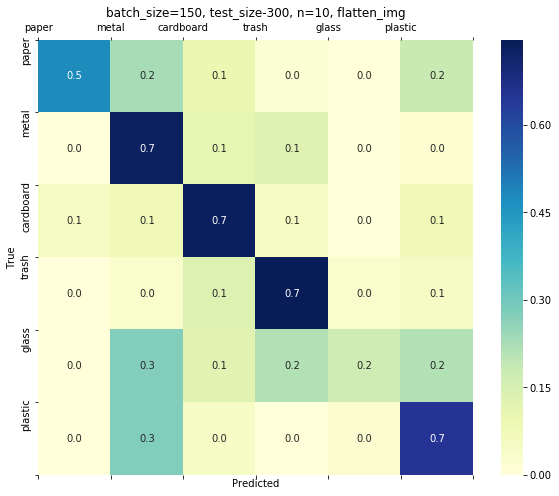

In [64]:
# results visulization
from sklearn.metrics import confusion_matrix
import seaborn as sns

desc, test_y, pred_y = trials[5]

print(classification_report(test_y, pred_y))

categories = ['paper','metal','cardboard','trash','glass','plastic']
cm = confusion_matrix(test_y, pred_y,labels=categories)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm,categories,categories)

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(df_cm,annot=True,fmt=".1f",cmap="YlGnBu")
cax = ax.matshow(cm)
plt.title(desc)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [132]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# feature extraction
img_extract = [to_orb_desc(img) for img in mixed_imgs]

# split test and train sets
Img_train, Img_test, label_train, label_test = \
train_test_split(img_extract, testing_num_labels, test_size=0.2, random_state=109)

# train model
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
]
svc = svm.SVC()
svm_model = GridSearchCV(svc, param_grid)
svm_model.fit(Img_train, label_train)

label_pred = svm_model.predict(Img_test)
print(classification_report(label_test, label_pred))

/Users/loaner/.local/share/virtualenvs/trash-classifier-Blx31XfF/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/loaner/.local/share/virtualenvs/trash-classifier-Blx31XfF/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: setting an array element with a sequence.

* ### Feature reduction

In [30]:
# single image testing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print('original shape: ', matrix_test.shape)

# scaling
ss = StandardScaler()
ss_trans = ss.fit_transform(matrix_test.reshape(-1,1))

# PCA
pca = PCA(n_components=1)
pca_trans = ss.transform(ss_trans)

# new shape
print('after transformation new shape is: ', pca_trans.shape)

original shape:  (2, 589824)
after transformation new shape is:  (1179648, 1)


In [31]:
pca_trans

array([[-4.59682663],
       [-4.62055739],
       [-4.63022548],
       ...,
       [-4.62231522],
       [-4.62934656],
       [-4.63901465]])